Installing tfds (tensorflow dataset) :

In [1]:
!pip install -q tfds-nightly
!tfds --version

     |████████████████████████████████| 3.7MB 7.6MB/s 
2021-01-17 16:16:56.381101: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
TensorFlow Datasets: 4.2.0+nightly


Clone the source repo from GitHub

In [2]:
!rm -rf Where_is*
!git clone "https://github.com/heolfief/Where_is_Waldo_AI_solver.git"
!cd Where_is_Waldo_AI_solver && git fetch --all && git checkout generateTestDataset

Cloning into 'Where_is_Waldo_AI_solver'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 118 (delta 41), reused 62 (delta 16), pack-reused 0
Receiving objects: 100% (118/118), 28.05 MiB | 46.55 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Fetching origin
Branch 'generateTestDataset' set up to track remote branch 'generateTestDataset' from 'origin'.
Switched to a new branch 'generateTestDataset'


Create the images for the dataset

In [3]:
!python Where_is_Waldo_AI_solver/scripts/image_cutter.py

Warning, the following process may be quite long
100% 18/18 [00:06<00:00,  2.59it/s]


Building the dataset from the python script:

In [4]:
!tfds build Where_is_Waldo_AI_solver/scripts/create_TFDS.py --overwrite

2021-01-17 16:18:15.568604: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
INFO[build.py]: Loading dataset Where_is_Waldo_AI_solver/scripts/create_TFDS.py from path: /content/Where_is_Waldo_AI_solver/scripts/create_TFDS.py
2021-01-17 16:18:18.033835: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-01-17 16:18:18.107354: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
INFO[build.py]: download_and_prepare for dataset waldo_dataset/1.0.0...
INFO[dataset_builder.py]: Generating dataset waldo_dataset (/root/tensorflow_datasets/waldo_dataset/1.0.0)
2021-01-17 16:18:18.253330: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token sinc

Testing the dataset :

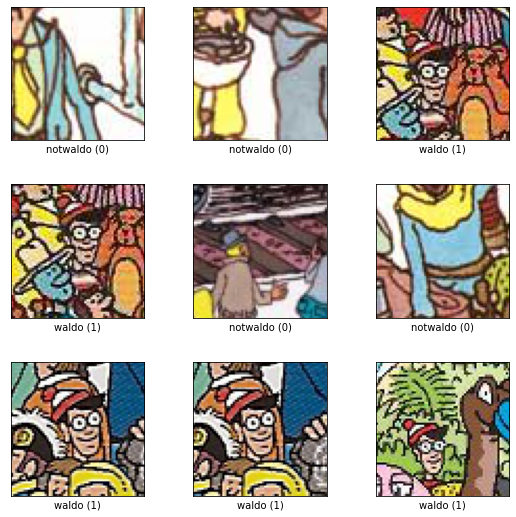

tfds.core.DatasetInfo(
    name='waldo_dataset',
    full_name='waldo_dataset/1.0.0',
    description="""
    Where is Waldo dataset
    """,
    homepage='https://github.com/heolfief/Where_is_Waldo_AI_solver',
    data_path='/root/tensorflow_datasets/waldo_dataset/1.0.0',
    download_size=Unknown size,
    dataset_size=12.46 MiB,
    features=FeaturesDict({
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=304, num_shards=1>,
        'train': <SplitInfo num_examples=837, num_shards=1>,
    },
    citation="""""",
)


In [5]:
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load('waldo_dataset', split=['train','test'], with_info=True,  shuffle_files=True, as_supervised=True)
fig = tfds.show_examples(ds_train, ds_info)
print(ds_info)


Display the distribution of labels over the splited dataset:

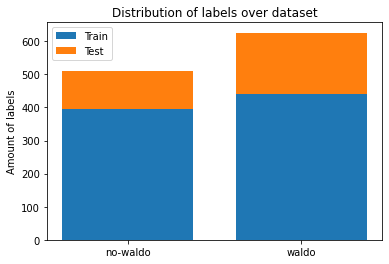

In [6]:
import collections
import numpy as np
import matplotlib.pyplot as plt

# Recover distribution of classes among datasets
def get_class_distribution(dataset):
    class_distribution = {}
    for element in dataset.as_numpy_iterator():
        label = element[1]

        if label in class_distribution.keys():
            class_distribution[label] += 1
        else:
            class_distribution[label] = 0

    # sort dict by key
    class_distribution = collections.OrderedDict(sorted(class_distribution.items())) 
    return class_distribution

train_distribution = get_class_distribution(ds_train)
test_distribution = get_class_distribution(ds_test)

# Plot distribution
indices = np.arange(len(train_distribution))
width = 0.75
train_plot = []
test_plot = []
for label, amount in train_distribution.items():
  train_plot.append(amount)
for label, amount in test_distribution.items():
  test_plot.append(amount)

p1 = plt.bar(indices, train_plot, width)
p2 = plt.bar(indices, test_plot, width, bottom=train_plot)
plt.ylabel('Amount of labels')
plt.title('Distribution of labels over dataset')
plt.xticks(indices, ('no-waldo', 'waldo'))
l = plt.legend((p1[0], p2[0]), ('Train', 'Test'))
plt.show()

**Build CNN :**

In the menu "Execution" -> modify execution type and select GPU. Once execution type is correctly configured, the GPU model should appaers below 

In [7]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4586308317575774937, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15692715840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16060842940016766754
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

Load dataset in a dataset class :

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,experimental
import time

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


In [70]:
CNN = Sequential()

data_augmentation = keras.Sequential(
  [
    experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 3)),
    experimental.preprocessing.RandomFlip("horizontal", input_shape=(64,64,3)),
    experimental.preprocessing.RandomContrast(0.35),
    experimental.preprocessing.RandomZoom(0.2),
  ]
)

CNN.add(data_augmentation)
CNN.add(Conv2D(64, (2, 2), input_shape=(64, 64, 3),
                      padding='valid',
                      name='Convolution-1',
                      activation='relu'))
CNN.add(Conv2D(64, (2, 2), padding='valid',
                      name='Convolution-2',
                      activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2),
                            name='Pooling-1'))
CNN.add(Dropout(0.5))

CNN.add(Conv2D(128, (2, 2), padding='valid',
                      name='Convolution-3',
                      activation='relu'))
CNN.add(Conv2D(128, (2, 2), padding='valid',
                      name='Convolution-4',
                      activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2),
                            name='Pooling-2'))
CNN.add(Dropout(0.5))

CNN.add(Conv2D(256, (2, 2), padding='valid',
                      name='Convolution-5',
                      activation='relu'))
CNN.add(Conv2D(256, (2, 2), padding='valid',
                      name='Convolution-6',
                      activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2),
                            name='Pooling-3'))
CNN.add(Dropout(0.6))

CNN.add(Flatten())
CNN.add(Dense(512,
                      name='Dense-1',
                      activation='relu'))
CNN.add(Dropout(0.4))

CNN.add(Dense(2,name='Dense-2',activation='softmax'))

CNN.compile(  loss=tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, 
    reduction="auto", 
    name="sparse_categorical_crossentropy"
    ),
    optimizer='adam',
    metrics=['accuracy']
    )

class_weight = {0: 1,
                1: train_plot[0]/train_plot[1]}

history = CNN.fit(ds_train, epochs=200, validation_data=ds_test)#, class_weight=class_weight)


Epoch 1/200
7/7 [==============================] - 1s 71ms/step - loss: 0.9518 - accuracy: 0.5131 - val_loss: 0.6928 - val_accuracy: 0.6118
Epoch 2/200
7/7 [==============================] - 0s 48ms/step - loss: 0.6928 - accuracy: 0.5370 - val_loss: 0.6911 - val_accuracy: 0.6118
Epoch 3/200
7/7 [==============================] - 0s 48ms/step - loss: 0.6926 - accuracy: 0.5295 - val_loss: 0.6870 - val_accuracy: 0.6118
Epoch 4/200
7/7 [==============================] - 0s 47ms/step - loss: 0.6917 - accuracy: 0.5243 - val_loss: 0.6821 - val_accuracy: 0.6118
Epoch 5/200
7/7 [==============================] - 0s 48ms/step - loss: 0.6933 - accuracy: 0.5177 - val_loss: 0.6836 - val_accuracy: 0.6118
Epoch 6/200
7/7 [==============================] - 0s 49ms/step - loss: 0.6907 - accuracy: 0.5115 - val_loss: 0.6668 - val_accuracy: 0.6118
Epoch 7/200
7/7 [==============================] - 0s 47ms/step - loss: 0.6847 - accuracy: 0.5180 - val_loss: 0.6441 - val_accuracy: 0.6118
Epoch 8/200
7/7 [===

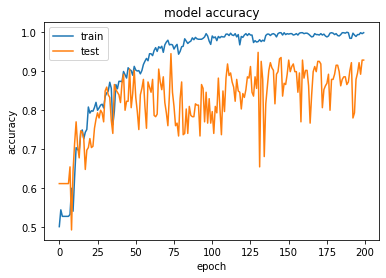

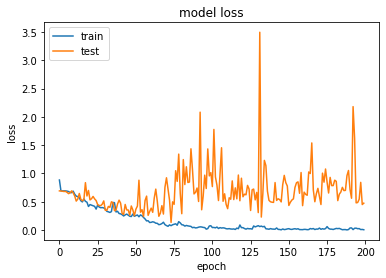

In [71]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


304
304
[[115   3]
 [ 19 167]]


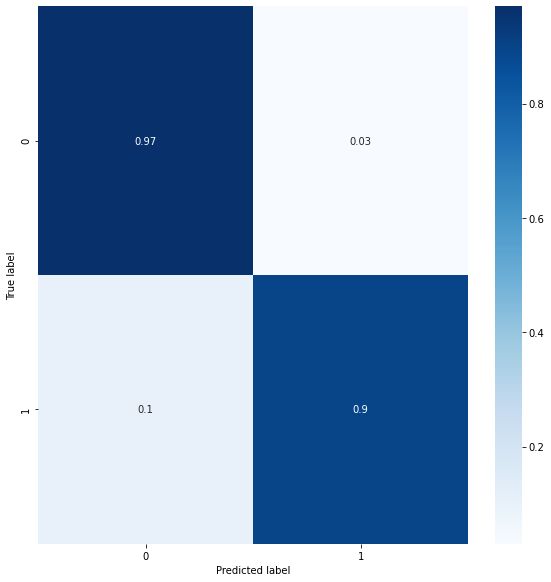

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

y_pred=CNN.predict_classes(ds_test)
print(y_pred.size)
true_categories = tf.concat([y for x, y in ds_test], axis=0)
print(true_categories.numpy().size)
con_mat = tf.math.confusion_matrix(labels=true_categories, predictions=y_pred).numpy()
print(con_mat)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes = [0, 1]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
